Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
import seaborn as sns
import sklearn
sklearn.__version__

'1.0.2'

In [2]:
plt.style.use(["dark_background"])
plt.rcParams["figure.figsize"] = [22.0, 8.0]

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [3]:
X, y = load_digits(n_class=10, return_X_y=True, as_frame=True)
assert X.shape == (1797, 64)
assert y.shape == (1797,)
# StandardScaler ухудшает читабельность картинок и некоторые метрики
# X = StandardScaler().fit_transform(X.values)
# X = MinMaxScaler().fit_transform(X)
X = X.astype(int).values
X.shape, y.shape

((1797, 64), (1797,))

In [4]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

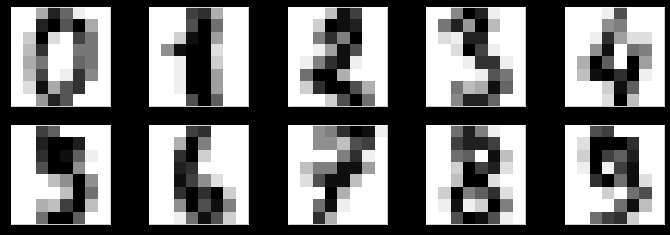

In [5]:
per_row = 5
fig, ax = plt.subplots(nrows=2, ncols=per_row, figsize=(12, 4), subplot_kw=dict(xticks=[], yticks=[]))
for row in [0, 1]:
    for col in range(per_row):
        _ = ax[row, col].imshow(X.reshape(-1, 8, 8)[row * per_row + col], cmap='gray_r')
plt.show()

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [6]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        """K-Means clustering.

        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also
                the number of centroids to generate.
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        """
        self.converged = False
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        self.rng = default_rng(self.random_state)
        self.cluster_centers_ = None
        self.saved_cluster_not_synced = []

    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j)
        is the distance from i-th object to j-th centroid."""
        # <your code>
        return euclidean_distances(X, cluster_centers)

    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) -
        new clusters that are found by averaging objects belonging
        to the corresponding cluster."""
        # <your code>
        n_features = X.shape[1]
        res = np.empty((self.n_clusters, n_features))
        for cluster_n in range(self.n_clusters):
            # cluster[n] = mean per feature (n_features)
            ind = nearest_clusters == cluster_n
            if ind.sum() == 0:
                print("ind.sum() == 0")
                print(f"cluster_n {cluster_n} has {ind.sum()} samples")
            res[cluster_n] = X[ind].mean(axis=0)
        return res

    def fit(self, X):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        # <your code>
        # print("max_iter", self.max_iter, "n_init", self.n_init)
        n_samples, n_features = X.shape
        # run n_init times, choose best
        objectives = []
        centroids_runs = []
        labels_runs = []
        for _ in range(self.n_init):
            # n_clusters unique numbers from [0 .. n_samples - 1]
            # len(np.unique(rng.choice(11111, size=11111, replace=False))) == 11111
            unique_rand_ints = self.rng.choice(n_samples, size=self.n_clusters, replace=False)
            # случайные точки как первичные центры
            centroids = np.array([X[i] for i in unique_rand_ints])
            # сортировка центров в попытке сделать их порядок предсказуемым
            centroids = centroids[centroids[:, 0].argsort()]

            for _ in range(self.max_iter):
                dist = self.calculate_distances_to_centroids(X, centroids)
                nearest_clusters = dist.argmin(axis=1)  # n_samples
                new_centroids = self.update_centroids(X, nearest_clusters)
                delta = np.linalg.norm(centroids - new_centroids, axis=1)
                centroids = new_centroids
                # print(_, delta)
                if delta.sum() == 0:
                    self.converged = True
                    break

            # calc objective for centroids and nearest_clusters
            dist = self.calculate_distances_to_centroids(X, centroids)
            nearest_clusters = dist.argmin(axis=1)
            objective = 0
            for cluster_n in range(self.n_clusters):
                points_in_cluster = X[nearest_clusters == cluster_n]
                diff = points_in_cluster - centroids[cluster_n]
                # assert diff.shape == (len(points_in_cluster), n_features)
                objective += np.linalg.norm(diff, axis=1).sum()
            centroids_runs.append(centroids)
            labels_runs.append(nearest_clusters)
            objectives.append(objective)
        # choose the best
        self.labels_ = labels_runs[np.argmin(objectives)]
        self.prev_cluster_centers = self.cluster_centers_
        self.cluster_centers_ = centroids_runs[np.argmin(objectives)]
        return self

    def predict(self, X):
        """Predict classes.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, "cluster_centers_"):
            # <your code>
            dist = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return dist.argmin(axis=1)
        else:
            raise NotFittedError("CustomKMeans instance is not fitted yet")

    def reorder_centroids(self, X, y, only_calc_true_cluster=False):
        """Попытка так выстроить найденные центры, чтобы метки распределились так же как в трейне.
        Т.е. при совпадении центров должна получаться точность 100% в accuracy_score.
        Проверенно на искусственных данных через make_blobs(centers=5).
        """
        n_features = X.shape[1]
        self.true_cluster_centers = np.empty((self.n_clusters, n_features))
        for cluster_n in range(self.n_clusters):
            # cluster[n] = mean per feature (n_features)
            ind = y == cluster_n
            self.true_cluster_centers[cluster_n] = X[ind].mean(axis=0)
        if only_calc_true_cluster:
            return
            # print("true cluster", cluster_n, self.true_cluster_centers[cluster_n], ind.sum())
        # print(f"self.cluster_centers_\n{self.cluster_centers_}")
        used_clusters = set()
        notused_src_clusters = set(range(self.n_clusters))
        notused_dst_clusters = set(range(self.n_clusters))
        reordered_found_centers = np.empty(self.cluster_centers_.shape)
        for cluster_n in range(self.n_clusters):
            diff = self.cluster_centers_ - self.true_cluster_centers[cluster_n]
            diff = np.linalg.norm(diff, axis=1)
            closest_cluster = diff.argmin(axis=0)
            # print(cluster_n, closest_cluster)
            if closest_cluster in used_clusters:
                # находит тот же кластер как ближний еще раз, случается из-за неправильной кластеризации.
                # если только один раз, то тогда понятно какой на какой надо поменять
                pass
            else:
                used_clusters.add(closest_cluster)
                notused_src_clusters.remove(closest_cluster)
                notused_dst_clusters.remove(cluster_n)
                reordered_found_centers[cluster_n] = self.cluster_centers_[closest_cluster]
                # points_of_the_cluster = self.labels_[self.labels_ == closest_cluster]
                # print("self.cluster_centers_[closest_cluster]:", self.cluster_centers_[closest_cluster])
                # print("true_cluster_centers[cluster_n]:", self.true_cluster_centers[cluster_n])
                # print("closest cluster", closest_cluster, ":", len(points_of_the_cluster))
        # print("notused_src_clusters", "notused_dst_clusters", notused_src_clusters, notused_dst_clusters)
        # обработка ненайденных, если больше чем 1, то будет случайная ошибка
        # возможна какая-то доработка
        self.saved_cluster_not_synced = []
        for src, dst in zip(notused_src_clusters, notused_dst_clusters):
            self.saved_cluster_not_synced.append({'src':src, 'dst': dst})
            reordered_found_centers[dst] = self.cluster_centers_[src]
        # print(f"old self.cluster_centers_\n{self.cluster_centers_}")
        self.cluster_centers_ = reordered_found_centers
        # print(f"new self.cluster_centers_\n{self.cluster_centers_}")
        self.labels_ = self.predict(X)


**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [7]:
km = CustomKMeans(n_clusters=10)
_ = km.fit(X)
km_skl = KMeans(n_clusters=10)
_ = km_skl.fit(X)
custom_kmeans_labels = km.labels_
assert custom_kmeans_labels.shape == (1797,)

In [8]:
def plot_centroids(centroids):
    per_row = 5
    _, ax = plt.subplots(nrows=2, ncols=per_row, figsize=(8, 3), subplot_kw=dict(xticks=[], yticks=[]))
    for row in [0, 1]:
        for col in range(per_row):
            _ = ax[row, col].imshow(centroids.reshape(-1, 8, 8)[row * per_row + col], cmap='gray_r')
    plt.show()

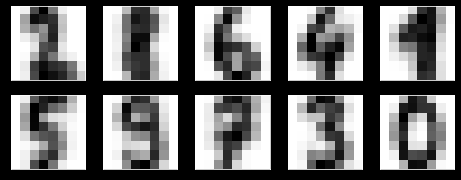

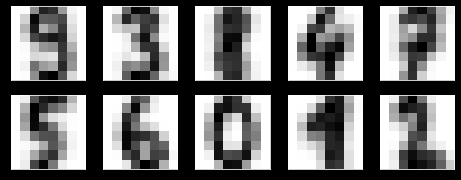

In [9]:
# сравниваю кастомный с библиотечным
# особой разницы не видно, с 8ой проблема у обоих
# km.reorder_centroids(X, y)
plot_centroids(km.cluster_centers_)
plot_centroids(km_skl.cluster_centers_)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [10]:
n_clusters = 10
n_init_max, max_iter_max = 7, 25
saved_objective = np.empty((n_init_max, max_iter_max))
saved_accuracy = np.empty((n_init_max, max_iter_max))
saved_cluster_not_synced = np.empty((n_init_max, max_iter_max), dtype=object)
# calc true_objective
kmtmp = CustomKMeans(n_clusters=10)
true_cluster_centers_ = kmtmp.update_centroids(X, y)
true_objective = 0
for cluster_n in range(n_clusters):
    points_in_cluster = X[y == cluster_n]
    diff = points_in_cluster - true_cluster_centers_[cluster_n]
    true_objective += np.linalg.norm(diff, axis=1).sum()

for n_init in range(1, n_init_max + 1):
    for max_iter in range(1, max_iter_max + 1):
        kmeans = CustomKMeans(n_clusters, max_iter=max_iter, n_init=n_init)
        _ = kmeans.fit(X)
        # kmeans.reorder_centroids(X, y, only_calc_true_cluster=True)
        kmeans.reorder_centroids(X, y)
        # save accuracy
        saved_accuracy[n_init - 1, max_iter - 1] = accuracy_score(y_pred=kmeans.labels_, y_true=y)
        saved_cluster_not_synced[n_init - 1, max_iter - 1] = kmeans.saved_cluster_not_synced
        # save objective
        dist = kmeans.calculate_distances_to_centroids(X, kmeans.cluster_centers_)
        nearest_clusters = dist.argmin(axis=1)
        objective = 0
        for cluster_n in range(n_clusters):
            points_in_cluster = X[nearest_clusters == cluster_n]
            diff = points_in_cluster - kmeans.cluster_centers_[cluster_n]
            objective += np.linalg.norm(diff, axis=1).sum()
        saved_objective[n_init - 1, max_iter - 1] = objective
        # print(kmeans.labels_.shape)


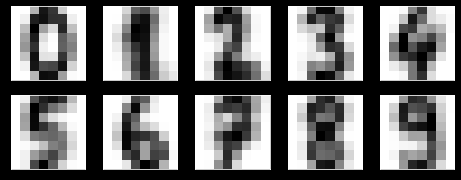

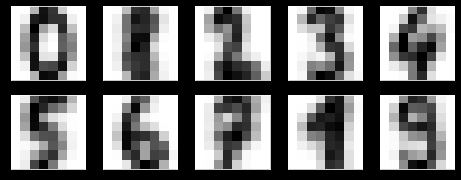

In [11]:
plot_centroids(kmeans.true_cluster_centers)
# в центроидах кастомного KMeans перепутаны 8 и 1
plot_centroids(kmeans.cluster_centers_)

In [12]:
# некоторые наблюдения
# считаю value_counts
# Сколько самплов попало в разные классы, видна большая разница, но это только для последней итерации.
# Попытка сделать saved_counts через np.linalg.norm для разных параметров ничего интересного не дала.
_, counts = np.unique(kmeans.labels_, return_counts=True)
counts1 = np.array(counts)
# counts1 = np.array(sorted(counts))
_, counts = np.unique(y, return_counts=True)
counts2 = np.array(counts)
# counts2 = np.array(sorted(counts))
print(counts1, counts.sum())
print(counts2, counts.sum())
print(np.linalg.norm(counts2 - counts1))
#
# при попытке найти соответствие между предсказываемыми и настоящими классами
# происходят некоторые потери, можно попробовать поанализировать если будет время.
np.set_printoptions(linewidth=100)
# saved_cluster_not_synced.shape (7, 25)
saved_cluster_not_synced[0, 0]
#
# оказалось, что true_objective (сумма расстояний для настоящих центров), хуже,
# чем минимальная objective для найденных центров
print(
    "true_objective:",
    true_objective.round(),
    "saved_objective min:",
    saved_objective.min().round(),
    "saved_objective max:",
    saved_objective.max().round(),
)

[178 221 174 178 166 147 182 211  92 248] 1797
[178 182 177 183 181 182 181 179 174 180] 1797
124.00806425390246


[{'src': 3, 'dst': 7}, {'src': 7, 'dst': 9}]

true_objective: 46083.0 saved_objective min: 44753.0 saved_objective max: 48796.0


In [13]:
def show_something(saved):
    saved_1 = saved / saved.max()
    _ = sns.heatmap(
        saved_1,
        annot=True,
        cbar=False,
        xticklabels=range(1, max_iter_max + 1),
        yticklabels=range(1, n_init_max + 1),
        robust=True,
    )
    return _

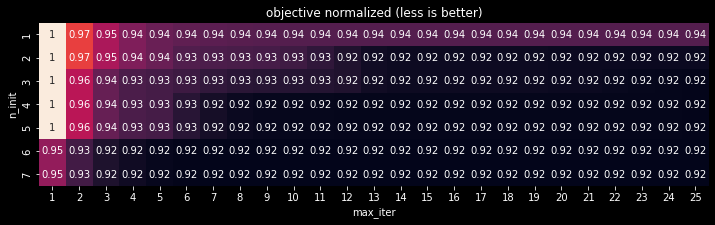

In [14]:
# вроде выглядит нормально, чем больше итераций, тем лучше
plt.rcParams["figure.figsize"] = [12.0, 3.0]
plot = show_something(saved_objective)
_ = plot.set_xlabel("max_iter")
_ = plot.set_ylabel("n_init")
_ = plot.set_title("objective normalized (less is better)")

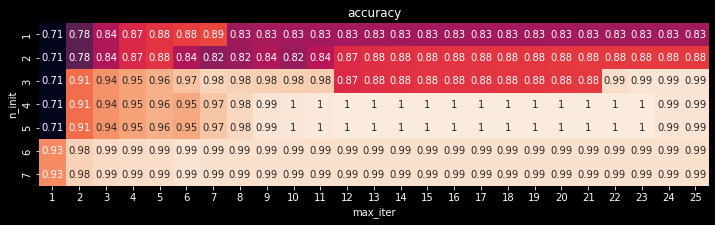

In [15]:
# Вроде более-менее хорошо получилось. Чем больше итераций, тем лучше. Но почему-то 0.99 вместо 1.
# Была замечена странная вещь - обжектив для настоящих меток оказался не самым лучшим.
# Т.е. минимум обжектива среди найденных бывает ниже (лучше) чем для настоящих меток.
# Идея: а что, если за обжектив попробовать взять расстояния до настоящих центров?
# Т.е. находить сумму расстояний от найденного центроида до ближайшего true центроида.
# Возможно тогда будут единицы внизу, а не 0.99. Может попробую потом.
plot = show_something(saved_accuracy)
_ = plot.set_xlabel('max_iter')
_ = plot.set_ylabel('n_init')
_ = plot.set_title('accuracy')

In [16]:
# в данном случае похоже основные проблемы с 9ой
kmeans = CustomKMeans(n_clusters=10, max_iter=15, n_init=4)
_ = kmeans.fit(X)
# kmeans.reorder_centroids(X, y, only_calc_true_cluster=True)
kmeans.reorder_centroids(X, y)
kmeans.saved_cluster_not_synced
confusion_matrix(y, kmeans.labels_)

[{'src': 0, 'dst': 9}]

array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 100,  25,   0,   0,   1,   2,   0,   0,  54],
       [  1,   1, 148,  11,   0,   0,   0,   2,  12,   2],
       [  0,   0,   2, 160,   0,   2,   0,   8,  11,   0],
       [  0,   5,   0,   0, 160,   0,   0,   7,   2,   7],
       [  0,   0,   0,  40,   1, 139,   2,   0,   0,   0],
       [  1,   3,   0,   0,   0,   0, 176,   0,   1,   0],
       [  0,   0,   0,   0,   0,   5,   0, 170,   2,   2],
       [  0,  11,   3,  12,   0,   5,   1,   2, 134,   6],
       [  0,   0,   0, 145,   0,   6,   0,   8,   1,  20]], dtype=int64)

In [17]:
# Без синхронизации центроидов (можно сделать через only_calc_true_cluster=True) 
# accuracy вообще стремится к нулю. А с синхронизацией красивое 0.77
"accuracy_score:", accuracy_score(y_pred=kmeans.labels_, y_true=y).round(2)
print(classification_report(y, kmeans.labels_, zero_division=0))

('accuracy_score:', 0.77)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.83      0.55      0.66       182
           2       0.83      0.84      0.83       177
           3       0.43      0.87      0.58       183
           4       0.99      0.88      0.93       181
           5       0.88      0.76      0.82       182
           6       0.97      0.97      0.97       181
           7       0.86      0.95      0.90       179
           8       0.82      0.77      0.80       174
           9       0.22      0.11      0.15       180

    accuracy                           0.77      1797
   macro avg       0.78      0.77      0.76      1797
weighted avg       0.78      0.77      0.76      1797



In [18]:
# для скайлерновского KMeans можно было бы сделать "синхронизацию центров", но лень.
# без синхронизации оно просто путает метки.
kmeans_skl = KMeans(n_clusters=10, max_iter=20, n_init=10)
_ = kmeans_skl.fit(X)
confusion_matrix(y, kmeans_skl.labels_)
print(classification_report(y, kmeans_skl.labels_, zero_division=0))

array([[  0,   0, 177,   0,   0,   0,   0,   0,   0,   1],
       [ 55,   1,   0,   0,  99,  24,   2,   0,   1,   0],
       [  2,   0,   1,   2,   8, 148,   0,   3,  13,   0],
       [  0,   2,   0,  12,   7,   0,   0,   7, 155,   0],
       [  7,   0,   0,   0,   2,   0,   0,  10,   0, 162],
       [  0, 136,   0,  41,   0,   0,   1,   0,   2,   2],
       [  1,   0,   1,   0,   2,   0, 177,   0,   0,   0],
       [  2,   0,   0,   0,   2,   0,   0, 175,   0,   0],
       [  6,   4,   0,  51, 101,   3,   2,   5,   2,   0],
       [ 20,   5,   0, 140,   1,   0,   0,   8,   6,   0]], dtype=int64)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       178
           1       0.01      0.01      0.01       182
           2       0.01      0.01      0.01       177
           3       0.05      0.07      0.06       183
           4       0.01      0.01      0.01       181
           5       0.00      0.00      0.00       182
           6       0.97      0.98      0.98       181
           7       0.84      0.98      0.90       179
           8       0.01      0.01      0.01       174
           9       0.00      0.00      0.00       180

    accuracy                           0.21      1797
   macro avg       0.19      0.21      0.20      1797
weighted avg       0.19      0.21      0.20      1797



Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [19]:
agg = AgglomerativeClustering(n_clusters=10, affinity="euclidean", linkage="ward")
_ = agg.fit(X)
hierarchical_labels = agg.labels_

In [20]:
km_skl = KMeans(n_clusters=10)
_ = km_skl.fit(X)
kmeans_labels = km_skl.labels_

In [21]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

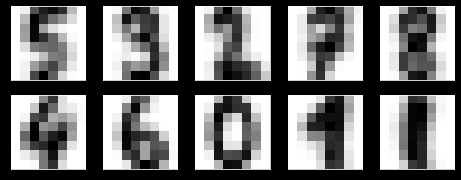

In [22]:
# hierarchical_labels
n_features = X.shape[1]
true_cluster_centers = np.empty((n_clusters, n_features))
for cluster_n in range(n_clusters):
    ind = hierarchical_labels == cluster_n
    true_cluster_centers[cluster_n] = X[ind].mean(axis=0)
plot_centroids(true_cluster_centers)
# 9ка (или 3ка?) потерялась и вместо нее еще одна 1?

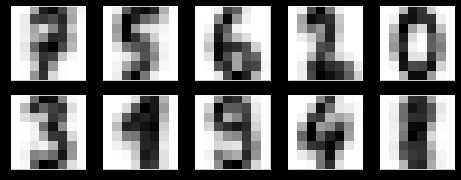

In [23]:
# kmeans_labels
for cluster_n in range(n_clusters):
    ind = kmeans_labels == cluster_n
    true_cluster_centers[cluster_n] = X[ind].mean(axis=0)
plot_centroids(true_cluster_centers)
# у kmeans 8ка не очень, у hierarchical_labels намного лучше

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [24]:
# X = StandardScaler().fit_transform(X)
# отключил скэйлер, как-то без него приятней
X.min(), X.max(), X.std()

(0, 16, 6.016787548672236)

In [25]:
K_min, K_max = 2, 20
K_len = K_max - K_min
saved_scores = np.empty((2, K_len + 1))
for K in range(K_min, K_max + 1):
    km_skl = KMeans(n_clusters=K)
    _ = km_skl.fit(X)
    saved_scores[0, K - K_min] = silhouette_score(X, km_skl.labels_)
    agg = AgglomerativeClustering(n_clusters=K)
    _ = agg.fit(X)
    saved_scores[1, K - K_min] = silhouette_score(X, agg.labels_)

KMeans 0.189
AgglomerativeClustering 0.181


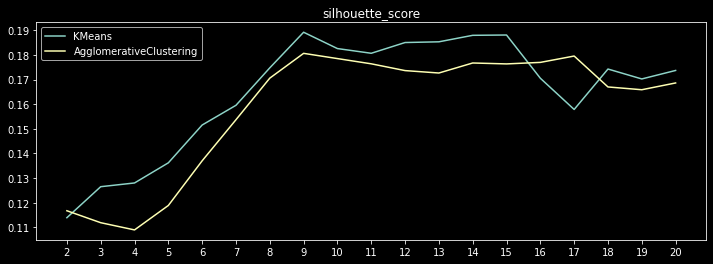

In [26]:
labels = ["KMeans", "AgglomerativeClustering"]
plt.rcParams["figure.figsize"] = [12.0, 4.0]
ax = sns.lineplot(x=range(K_len + 1), y=saved_scores[0])
ax = sns.lineplot(x=range(K_len + 1), y=saved_scores[1], ax=ax)
_ = ax.set_title("silhouette_score")
_ = ax.legend(labels=labels)
_ = ax.set_xticks(range(K_len + 1))
_ = ax.set_xticklabels(range(K_min, K_max + 1))
for i, label in enumerate(labels):
    print(label, saved_scores[i].max().round(3))

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [27]:
for K in range(K_min, K_max + 1):
    km_skl = KMeans(n_clusters=K)
    _ = km_skl.fit(X)
    saved_scores[0, K - K_min] = v_measure_score(y, km_skl.labels_)
    agg = AgglomerativeClustering(n_clusters=K)
    saved_scores[1, K - K_min] = v_measure_score(y, agg.fit_predict(X))

KMeans 0.794
AgglomerativeClustering 0.869


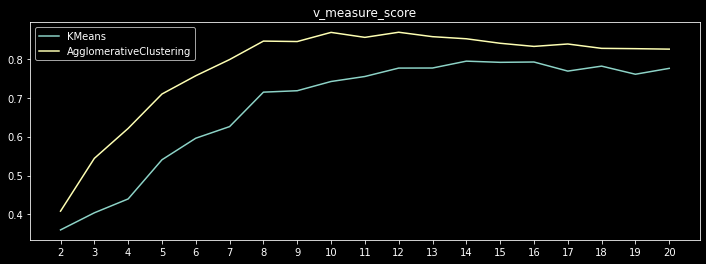

In [28]:
ax = sns.lineplot(x=range(K_len + 1), y=saved_scores[0])
ax = sns.lineplot(x=range(K_len + 1), y=saved_scores[1], ax=ax)
_ = ax.set_title('v_measure_score')
_ = ax.legend(labels=labels)
_ = ax.set_xticks(range(K_len + 1))
_ = ax.set_xticklabels(range(K_min, K_max + 1))
for i, label in enumerate(labels):
    print(label, saved_scores[i].max().round(3))

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [29]:
from sklearn.decomposition import TruncatedSVD
n_comp_svd = [2, 5, 9, 10, 11, 20]
saved_scores = np.empty((4, len(n_comp_svd)))
n_clusters = 10
for i, n in enumerate(n_comp_svd):
    svd = TruncatedSVD(n_components=n, random_state=42)
    X_svd = svd.fit_transform(X)
    km_skl = KMeans(n_clusters=n_clusters)
    _ = km_skl.fit(X_svd)
    saved_scores[0, i] = silhouette_score(X, km_skl.labels_)
    saved_scores[1, i] = v_measure_score(y, km_skl.labels_)
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    _ = agg.fit(X_svd)
    saved_scores[2, i] = silhouette_score(X, agg.labels_)
    saved_scores[3, i] = v_measure_score(y, agg.fit_predict(X_svd))

KMeans silhouette 0.182
KMeans v_measure 0.741
AC silhouette 0.178
AC v_measure 0.826


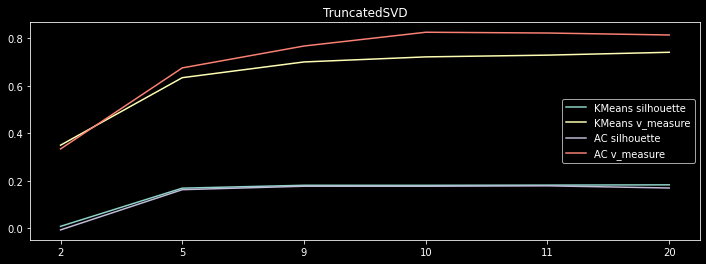

In [30]:
labels = ["KMeans silhouette", "KMeans v_measure", "AC silhouette", "AC v_measure"]
ax = sns.lineplot(x=range(len(n_comp_svd)), y=saved_scores[0])
ax = sns.lineplot(x=range(len(n_comp_svd)), y=saved_scores[1], ax=ax)
ax = sns.lineplot(x=range(len(n_comp_svd)), y=saved_scores[2], ax=ax)
ax = sns.lineplot(x=range(len(n_comp_svd)), y=saved_scores[3], ax=ax)
_ = ax.legend(labels=labels)
_ = ax.set_xticks(range(len(n_comp_svd)))
_ = ax.set_xticklabels(n_comp_svd)
_ = ax.set_title("TruncatedSVD")
for i, label in enumerate(labels):
    print(label, saved_scores[i].max().round(3))

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

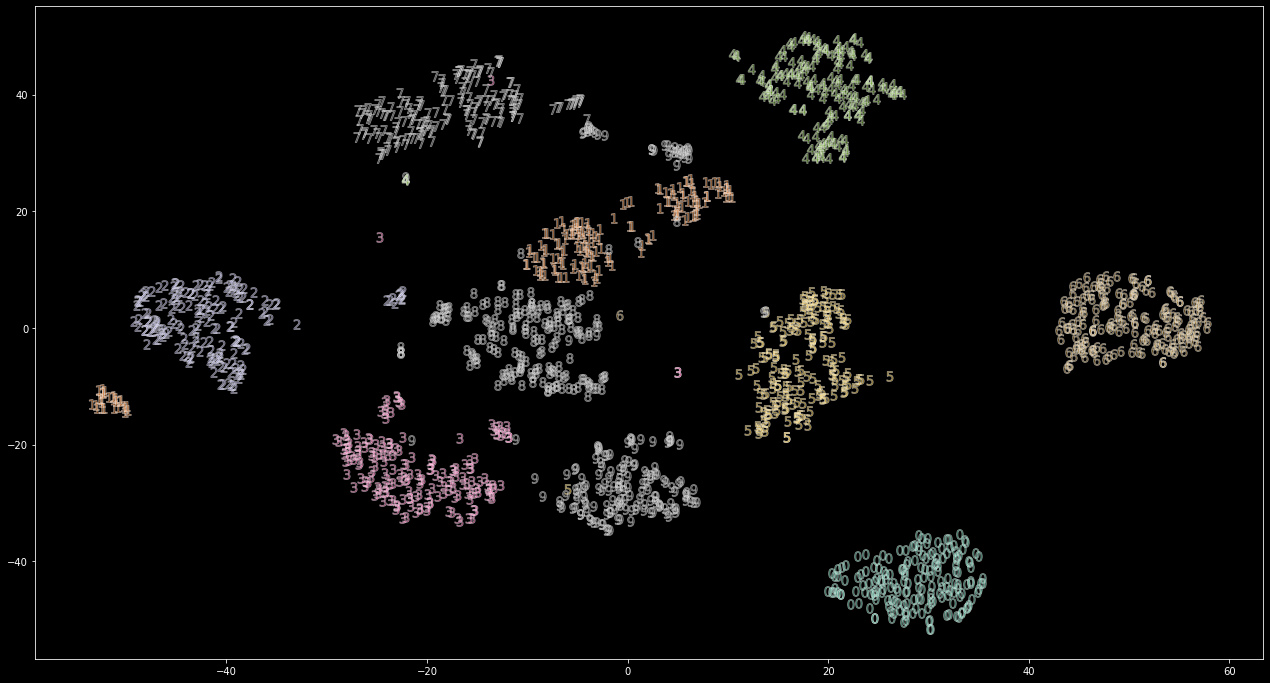

In [31]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(X)
plt.rcParams["figure.figsize"] = [22.0, 12.0]
for digit in np.unique(y):
    _ = sns.scatterplot(
        x=X_tsne[y == digit][:,0],
        y=X_tsne[y == digit][:,1],
        marker=f"${digit}$",
        s=100,
        color=plt.cm.Dark2(digit),
        alpha=0.5,
        zorder=2,
    )

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [32]:
km_skl = KMeans(n_clusters=n_clusters)
_ = km_skl.fit(X)
print('KMeans silhouette org', silhouette_score(X, km_skl.labels_).round(2))
print('KMeans v_measure org', v_measure_score(y, km_skl.labels_).round(2))
_ = km_skl.fit(X_tsne)
print('KMeans silhouette tsne', silhouette_score(X, km_skl.labels_).round(2))
print('KMeans v_measure tsne', v_measure_score(y, km_skl.labels_).round(2))
agg = AgglomerativeClustering(n_clusters=n_clusters)
_ = agg.fit(X)
print('AC silhouette org', silhouette_score(X, agg.labels_).round(2))
print('AC v_measure org', v_measure_score(y, agg.fit_predict(X)).round(2))
_ = agg.fit(X_tsne)
print('AC silhouette tsne', silhouette_score(X, agg.labels_).round(2))
print('AC v_measure tsne', v_measure_score(y, agg.fit_predict(X_tsne)).round(2))
# 
# silhouette KMeans 0.191 AgglomerativeClustering 0.181
# v_measure KMeans 0.787 AgglomerativeClustering 0.869

KMeans silhouette org 0.18
KMeans v_measure org 0.74
KMeans silhouette tsne 0.16
KMeans v_measure tsne 0.91
AC silhouette org 0.18
AC v_measure org 0.87
AC silhouette tsne 0.16
AC v_measure tsne 0.92


**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

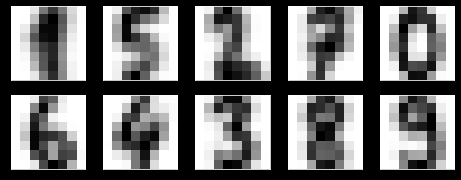

In [33]:
# Choose the best partition
# AC v_measure tsne 0.92
# Did you managed to make each digit correspond to one center of the cluster?
# Раз в каждой картинке узнается своя уникальная цифра, то значит да.
centroids = np.empty((n_clusters, n_features))
y_pred = agg.fit_predict(X_tsne)
for cluster_n in range(n_clusters):
    centroids[cluster_n] = X[y_pred == cluster_n].mean(axis=0)
plot_centroids(centroids)

acc with simple X: 0.763


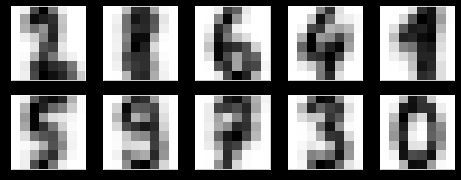

acc with X_tsne: 0.884


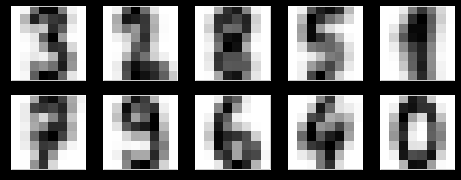

In [34]:
def show_custom_acc(msg, X_or_X_tsne):
    kmeans = CustomKMeans(n_clusters=10, max_iter=15, n_init=10)
    _ = kmeans.fit(X_or_X_tsne)
    y_pred = kmeans.predict(X_or_X_tsne)
    for cluster_n in range(n_clusters):
        centroids[cluster_n] = X[y_pred == cluster_n].mean(axis=0)
    kmeans.cluster_centers_ = centroids
    kmeans.reorder_centroids(X, y)
    print(msg, accuracy_score(y, kmeans.labels_).round(3))
    plot_centroids(centroids)


show_custom_acc("acc with simple X:", X)
# через X_tsne 8ка получается явно лучше и видимо поэтому и точность выше
show_custom_acc("acc with X_tsne:", X_tsne)

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

In [35]:
# Что значит "meaningful results"? Есть плюсы и минусы у каждого подхода.
# В обоих можно работать дальше над улучшением. На данном (поверхностном) этапе 
# hierarchical clustering выглядит чуть лучше.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

In [36]:
# Можно вычислить центроиды от разметки, полученной от hierarchical clustering и 
# использовать их для предсказаний.

**(0.5 points)** Does dimensionality reduction improve clustering results?

In [37]:
# Да, TSNE хорошо себя показал.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

In [38]:
# 1. Построить две модели "до" и "после", сравнить метриками
# 2. Нарисовать графики и глазами посмотреть красиво или нет 

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [39]:
# Не нашлось времени на это.